Quantified backlog state = Sum(Rule \* Weight \* 10)

This will give the team clear information about backlog state score in a number from 1-10 (1 - worst, 10 - best )
Weights need to sum up to 100%



In [1]:
from jira import JIRA
import matplotlib.pyplot as plt
import pandas as pd
import re
from numpy import nan
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:


#to show all rules descriptions
pd.set_option('max_colwidth',200)

rules = pd.DataFrame()
rules['rule'] = ''
rules['weight'] = 0
rules['value'] = 0

rules['rule'] = ['In next 2 sprints there are items in Backlog state that SP sum is equal to estimated velocity (+-20%) and status is not in presprint - Y/N',
                'Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - [% of planned sprints]',
                '% of Must, Urgent, Should items that are estimated regardless of status',
                '% of key milestone items estimated and in Backlog status']
rules['weight'] = [0.4, 0.25, 0.25, 0.1]

rules

,rule,weight,value
0,In next 2 sprints there are items in Backlog state that SP sum is equal to estimated velocity (+-20%) and status is not in presprint - Y/N,0.40,NaN
1,Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - [% of planned sprints],0.25,NaN
2,"% of Must, Urgent, Should items that are estimated regardless of status",0.25,NaN
3,% of key milestone items estimated and in Backlog status,0.10,NaN


Rules sum should be 1

In [3]:
sum(rules.weight)

1.0

<div class="alert alert-block alert-success">
Set up nextSprint, currentVersion, nextVersion values.

They can be loaded automatically from Jira too.
</div>

In [4]:
#velocity used to check if sprints are planned correctly
estimatedVelocity = 20

nextVersions = ['1.12', '1.13', '1.14', '1.15', '1.16']
milestones = ['Frimley MVP']

In [5]:
jira_url = 'https://kainos-evolve.atlassian.net'
jira = JIRA(jira_url)

In [6]:
#download next 2 sprints names
from jira.client import GreenHopper
options = {'server': jira_url}
gh = GreenHopper(options)
sprintsRaw = gh.sprints(285)

sprints = pd.DataFrame()
sprints['name'] = ''
sprints['state'] = ''

for sprint in sprintsRaw:
    sprints = sprints.append(
            {
                'name': sprint.name,
                'state': sprint.state
            }, ignore_index=True)
sprints = sprints.loc[(sprints['state'] == 'FUTURE')]
sprints.sort_values("name", inplace=True)

nextSprints = sprints.head(2)['name'].tolist()
nextSprints

['IC - #6 20180319 - 1.14', 'IC - #7 20180404 - 1.15']

In [7]:
#rule 0
#In next 2 sprints there are items in Backlog state that SP sum is equal to estimated velocity (+-20%), 
#there are no items assigned to sprint that are not in presprint states - Y/N
#bugs don't have to be estimated

jql = 'sprint in ("{}") and status in (Backlog, "Ready to test") and type not in subTaskIssueTypes()'.format('", "'.join(nextSprints))
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['sprint'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

for issue in issuesRaw:
    for rawSprint in issue.fields.customfield_10007:
        #unfortunately sprint information is encoded and regex is needed
        matches = re.search('name=(.*?),', rawSprint)
        currentSprint = matches.group(1)
        if(currentSprint in nextSprints):
            issues = issues.append(
                {
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP' : issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'sprint' : currentSprint
                }, ignore_index=True)


issues.fillna(value=nan, inplace=True)            

#bugs don't have to be estimated
issues.loc[(issues['type'] == 'Bug') & (issues['SP'].isnull()), ['SP']] = 0
            

issues
#issues.fillna(0, inplace=True)


sprints = issues.groupby(['sprint']).agg({'SP':'sum'})
sprints

sprints = sprints.loc[(sprints['SP'] >= estimatedVelocity - estimatedVelocity * 0.2) &
                     (sprints['SP'] <= estimatedVelocity + estimatedVelocity * 0.2)]
sprints
# % of estimated sprints
rule_value = len(sprints) / len(nextSprints)
rule_value
rules.at[0, 'value'] = rule_value

'sprint in ("IC - #6 20180319 - 1.14", "IC - #7 20180404 - 1.15") and status in (Backlog, "Ready to test") and type not in subTaskIssueTypes()'

,key,sprint,SP,type,status,summary
0,VXT-3993,IC - #6 20180319 - 1.14,3.0,Bug,Backlog,Low performance and low availability indicators in SSO login flow
1,VXT-3904,IC - #6 20180319 - 1.14,1.0,Story,Ready to Test,Add Keycloak theme Deployment to SSO Installer
2,VXT-3678,IC - #6 20180319 - 1.14,3.0,Story,Backlog,Custom Controls - Unable to identify version number
3,VXT-2377,IC - #7 20180404 - 1.15,3.0,External Bug,Backlog,PSQLException: ERROR: index row size 3056 exceeds maximum 2712


,SP
sprint,
IC - #6 20180319 - 1.14,7.0
IC - #7 20180404 - 1.15,3.0


,SP
sprint,


0.0

In [8]:
#rule 1 Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N
jql = 'fixVersion in ("{}") and type not in subTaskIssueTypes()'.format('", "'.join(nextVersions))
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in nextVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'team' : str(issue.fields.customfield_14200),
                }, ignore_index=True)
            
issues = issues.loc[~(issues['status'].isin(['Completed', 'Rejected']))]

#indicate not estimated issues, bugs don't have to be estimated
issues['isEstimated'] = False
issues.loc[(issues['type'].isin(['Bug', 'Epic'])), ['isEstimated']] = True
issues.loc[(issues['type'] != 'Bug') & ~(issues['SP'].isnull()), ['isEstimated']] = True

#indicate items in presprint
issues['inPresprint'] = False
issues.loc[(issues['status'].isin(['Awaiting Prioritisation', 'PO Refinement', 'UX Refinement', 'QA Refinement', 'Tech Refinement', 
                                  'Tech Refinement', 'Estimation'])), ['inPresprint']] = True
issues.sort_values("version", inplace=True)

issues = issues.loc[(issues['inPresprint'] == True) | (issues['isEstimated'] == False)]
issues

rule_value = len(issues) == 0
rules.at[1, 'value'] = int(rule_value)


'fixVersion in ("1.12", "1.13", "1.14", "1.15", "1.16") and type not in subTaskIssueTypes()'

,key,version,SP,type,status,summary,team,isEstimated,inPresprint
12,VXT-4063,1.15,NaN,Story,Tech Refinement,Allow for ordering of report based on key fields/metrics,Gdansk Team 1,False,True
11,VXT-4064,1.15,NaN,Story,Tech Refinement,Provide access to Reporting tool,Gdansk Team 1,False,True
10,VXT-4065,1.15,NaN,Story,Tech Refinement,Enable the ability to build custom reports from reporting tool,Gdansk Team 1,False,True
9,VXT-4066,1.15,NaN,Story,Tech Refinement,Configure/Enable sharing of reports across a tenant,Gdansk Team 1,False,True
13,VXT-4062,1.15,8.0,Story,Tech Refinement,Provide ability to generate a report for a multiple encounters/processes in a given date range,Gdansk Team 1,True,True
14,VXT-4061,1.15,8.0,Story,Tech Refinement,Build and provide ability to generate a report for a single process,Gdansk Team 1,True,True
28,VXT-3986,1.16,NaN,Story,Backlog,Keycloak HA,Gdansk Team 1,False,False


In [9]:
#rule 2
# % of Must, Urgent, Should items that are estimated regardless of status
# bugs don't have to be estimated
jql = 'project = VXT and priority in (Must,Urgent,Should) and type != Bug and type not in subTaskIssueTypes()'
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''
issues['priority'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in nextVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'priority' : str(issue.fields.priority.name),
                }, ignore_index=True)
issues

rule_value = round(len(issues.loc[~(issues['SP'].isnull())]) / len(issues), 2)
rules.at[2, 'value'] = rule_value

'project = VXT and priority in (Must,Urgent,Should) and type != Bug and type not in subTaskIssueTypes()'

,key,version,SP,type,status,summary,priority
0,VXT-4154,1.15,2.0,Story,Backlog,Release 1.15,MUST
1,VXT-4153,1.14,2.0,Story,Backlog,Release 1.14,MUST
2,VXT-4148,1.13,2.0,Story,Backlog,Release 1.13,MUST
3,VXT-4109,1.13,3.0,Story,Ready to Test,Encounter Screen - Rework of search filter options displayed to users,URGENT
4,VXT-4100,1.13,3.0,Story,Completed,Encounter Screen - Rework of default form task retrieval,URGENT
5,VXT-4098,1.12,1.0,Story,Completed,Set associated limits across production account / region,SHOULD
6,VXT-4092,1.12,2.0,Story,Completed,Release 1.12,SHOULD


In [10]:
# % of key milestone items estimated and in Backlog status
jql = 'project = VXT and type != Epic and status not in (Rejected, Completed) and type not in subTaskIssueTypes() and fixVersion in ("' + '", "'.join(milestones) + '")'
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in milestones):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                }, ignore_index=True)
            
issues['isEstimated'] = False
issues.loc[(issues['type'] == 'Bug'), ['isEstimated']] = True
issues.loc[(issues['type'] != 'Bug') & ~(issues['SP'].isnull()), ['isEstimated']] = True
issues

rule_value = round(len(issues.loc[(issues['isEstimated'] == True)]) / len(issues), 2)
rule_value
rules.at[3, 'value'] = rule_value

'project = VXT and type != Epic and status not in (Rejected, Completed) and type not in subTaskIssueTypes() and fixVersion in ("Frimley MVP")'

,key,version,SP,type,status,summary,isEstimated
0,VXT-4154,Frimley MVP,2.0,Story,Backlog,Release 1.15,True
1,VXT-4153,Frimley MVP,2.0,Story,Backlog,Release 1.14,True
2,VXT-4150,Frimley MVP,NaN,Story,Tech Refinement,Add 'Practitioner Display' to the Encounter data model so it can be displayed in forms,False
3,VXT-4148,Frimley MVP,2.0,Story,Backlog,Release 1.13,True
4,VXT-4145,Frimley MVP,NaN,Story,Tech Refinement,Allow FHIR table to optionally read and save updates to process,False
5,VXT-4143,Frimley MVP,NaN,Story,Tech Refinement,Extend Patient data model for deceased/date of death,False
6,VXT-4109,Frimley MVP,3.0,Story,Ready to Test,Encounter Screen - Rework of search filter options displayed to users,True
7,VXT-4087,Frimley MVP,1.0,Bug,In Development,Tab status for required fields is not refreshing on time for text fields,True
8,VXT-4085,Frimley MVP,NaN,Bug,Backlog,JIT user recreation fails due to autogenerated user id's and no-deletion policy in BPM,True
9,VXT-4077,Frimley MVP,NaN,Bug,Backlog,DOB format is incorrect of Patient when displaying on the form. It should match the banner.,True


0.76

In [11]:
rules['score'] = rules.weight * rules.value * 10
rules

,rule,weight,value,score
0,In next 2 sprints there are items in Backlog state that SP sum is equal to estimated velocity (+-20%) and status is not in presprint - Y/N,0.40,0.00,0.00
1,Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - [% of planned sprints],0.25,0.00,0.00
2,"% of Must, Urgent, Should items that are estimated regardless of status",0.25,1.00,2.50
3,% of key milestone items estimated and in Backlog status,0.10,0.76,0.76


Stored 'scores' (DataFrame)
Backlog score 3.26 / 10


(0, 10)

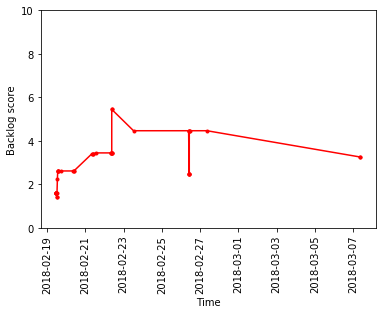

In [12]:
score = round(sum(rules['score']), 2)

#refresh stored data
%store -r

#if data frame for scores is not loaded create it
if not 'scores' in globals():
    scores = pd.DataFrame()
    scores['date'] = ''
    scores['score'] = 0

#append latest score
scores = scores.append(
            {
             'date': pd.to_datetime('now'),
             'score': score,
            }, ignore_index=True)

#store scores for later use
%store scores

print("Backlog score {} / 10".format(score))

_ = plt.plot(scores['date'], scores['score'], "-r.")

_ = plt.xticks(rotation='vertical')
_ = plt.ylabel('Backlog score')
_ = plt.xlabel('Time')
axes = plt.gca()
axes.set_ylim([0,10])

